[Using google's Lightweight MMM packag with channel/adstock tuning and exporting modelled response curves](https://colab.research.google.com/drive/1zKHmT_CR6AmVbH-4PdsmUJdumMadcmrO#scrollTo=WcYeesq4w3jT)

In [1]:
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro
import pandas as pd
import numpy as np
from jax.random import PRNGKey


# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

from sklearn.metrics import mean_absolute_percentage_error
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, init_to_value

from prjpkg import globalsettings as gs
from prjpkg.tools import adstock, hill

%load_ext autoreload
%autoreload 2


c:\Users\migue\Documents\tst_lightweight\.venv\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\migue\Documents\tst_lightweight\.venv\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\migue\Documents\tst_lightweight\.venv\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


c:\Users\migue\Documents\tst_lightweight\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Precision 64

In [2]:
# https://github.com/google/lightweight_mmm/issues/136

from jax.config import config
config.update('jax_enable_x64', True)

# Need costs

In [3]:
SEED = 105
channel_names=['social','tv', 'sem', 'display', 'programmatic']

data_size = (52*3) + 26 # we'll be using 3 years of weekly data for trainingdata, and adding half a year as our test data
n_media_channels = len(channel_names)
n_extra_features = 5

media_data, extra_features, target, costs = utils.simulate_dummy_data(
    data_size        = data_size,
    n_media_channels = n_media_channels,
    n_extra_features = n_extra_features)

# Split and scale data.
split_point = data_size - 26

# Media data
media_data_train = media_data[:split_point, ...]
media_data_test  = media_data[split_point:, ...]

# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test  = extra_features[split_point:, ...]

# Target
target_train = target[:split_point]

media_scaler          = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler         = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler           = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train     = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train         = target_scaler.fit_transform(target_train)
costs                = cost_scaler.fit_transform(costs)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Tuning

### beta_media

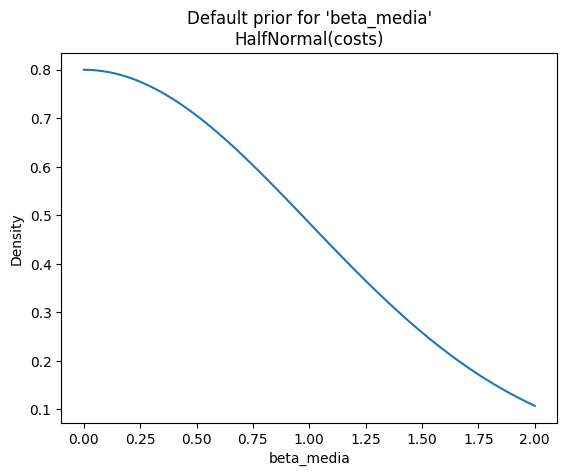

In [4]:
from numpyro import distributions as dist
import matplotlib.pyplot as plt
from jax.scipy.special import expit
from jax import lax, random

x = jnp.linspace(0, 2, 101)
plt.plot(x, jnp.exp(dist.HalfNormal(costs[0]).log_prob(x)))
plt.gca().set(xlabel="beta_media", ylabel="Density", 
              title = "Default prior for 'beta_media'\nHalfNormal(costs)")
plt.show()

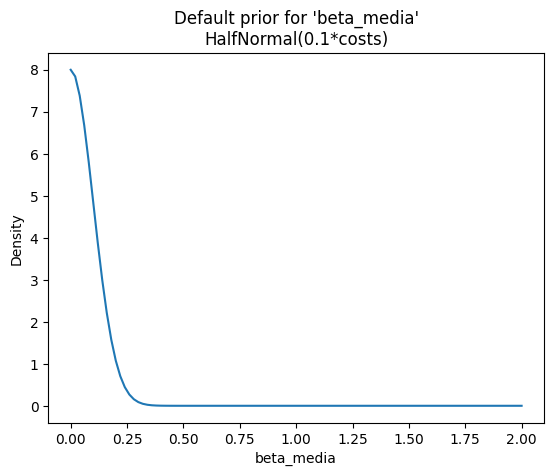

In [5]:
x = jnp.linspace(0, 2, 101)
plt.plot(x, jnp.exp(dist.HalfNormal(0.1*costs[0]).log_prob(x)))
plt.gca().set(xlabel="beta_media", ylabel="Density", 
              title = "Default prior for 'beta_media'\nHalfNormal(0.1*costs)")
plt.show()

### Adstock

 “lag_weight” Default prior: `numpyro.distributions.Beta(concentration1=2., concentration0=1.)`

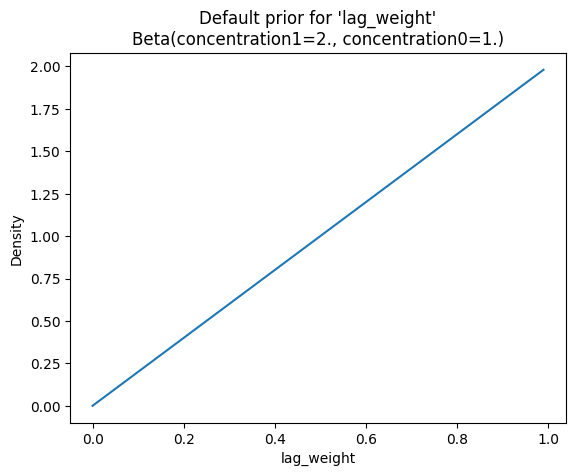

In [6]:
## Example of the adstock's probability density

x = jnp.linspace(0, 1, 101)
plt.plot(x, jnp.exp(dist.Beta(concentration1=2, concentration0=1.).log_prob(x)))
plt.gca().set(xlabel="lag_weight", ylabel="Density", 
              title = "Default prior for 'lag_weight'\nBeta(concentration1=2., concentration0=1.)")
plt.show()

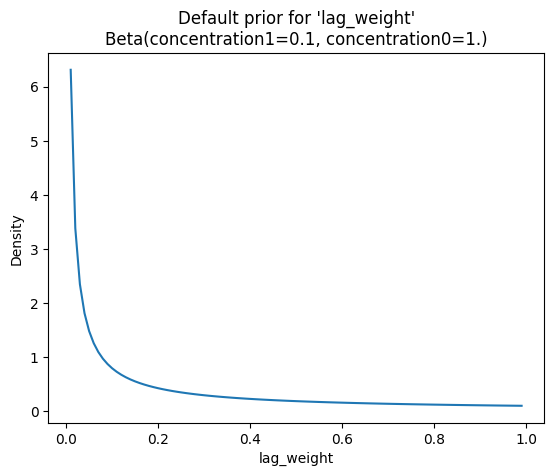

In [7]:
## here is the probability when trying to reduce the adstock's effect to be near 0

x = jnp.linspace(0, 1, 101)
plt.plot(x, jnp.exp(dist.Beta(concentration1=0.1, concentration0=1).log_prob(x)))
plt.gca().set(xlabel="lag_weight", ylabel="Density", 
              title = "Default prior for 'lag_weight'\nBeta(concentration1=0.1, concentration0=1.)")
plt.show()

### Hill

“half_max_effective_concentration” default prior: `numpyro.distributions.Gamma(concentration=1., rate=1.)`

“slope”: default prior: `numpyro.distributions.Gamma(concentration=1., rate=1.)`

Text(0, 0.5, 'Channel Contribution')

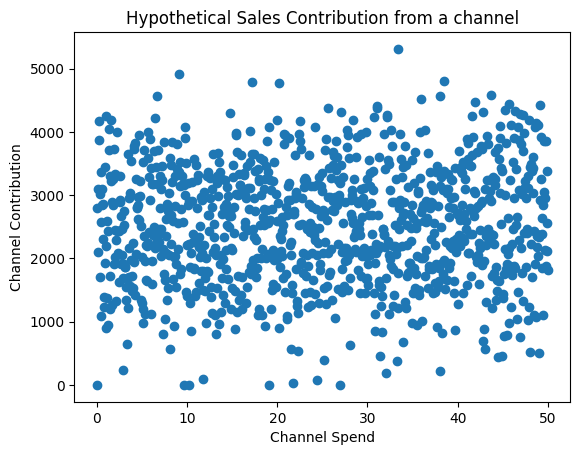

In [8]:
# Esto es el prior predictive de beta_media, half_eff, slope y lag_weight con
# las priors por defecto

##randomkey to generate new coefficient sampling
key=PRNGKey(456)

test_media=jnp.linspace(0, 50, 1000)

cost=jnp.sum(test_media*0.15)

beta_media = numpyro.sample("beta_media", dist.HalfNormal(cost), rng_key=key)
half_eff   = numpyro.sample("half_eff",   dist.Gamma(concentration=1., rate=1.), rng_key=key)
lag        = numpyro.sample("lag",        dist.Beta(concentration1=1., concentration0=1.),rng_key=key)
slope_     = numpyro.sample("slope",      dist.Gamma(concentration=1., rate=1.), rng_key=key)

x=test_media
y=beta_media*hill(
    data=adstock(
        data=test_media.reshape(-1,1), lag_weight=lag, normalise=True),
    half_max_effective_concentration=half_eff,
    slope=slope_)

y_noise=(y+(np.random.normal(350, 900, len(x))).reshape(-1,1))+np.random.randint(0,6,len(x)).reshape(-1,1)
y_noise=y_noise.at[y_noise < 0].set(0)

plt.title("Hypothetical Sales Contribution from a channel")
plt.scatter(x,y_noise)
plt.xlabel("Channel Spend")
plt.ylabel("Channel Contribution")

In [9]:
print(cost)
print(beta_media)
print(half_eff)
print(lag)
print(slope_)

3749.9999999999995
3962.995793776738
0.02582987132328802
0.09009073401624333
0.02582987132328802


In [10]:
# Modelo numpyro con las priors por defecto - como las reales con las que
# se han generado los datos
def hill_model(x,cost,y):
    beta_media=numpyro.sample("beta_media", dist.HalfNormal(cost))
    half_eff  =numpyro.sample("half_eff",   dist.Gamma(concentration=1., rate=1.))
    lag       =numpyro.sample("lag",        dist.Beta(concentration1=1., concentration0=1.))
    slope_    =numpyro.sample("slope",      dist.Gamma(concentration=1., rate=1.))


    y_pred=numpyro.deterministic('y_pred',beta_media*hill(
            data=adstock(
                data=x.reshape(-1,1), lag_weight=lag, normalise=True),
            half_max_effective_concentration=half_eff,
            slope=slope_))
    mu = numpyro.deterministic(name="mu", value=y_pred)

    with numpyro.plate(name="sigma_plate", size=1):
        sigma = numpyro.sample(
            name="sigma",
            fn=dist.Gamma(concentration=1., rate=1.))

    numpyro.sample(
      name="target", fn=dist.Normal(loc=mu, scale=sigma), obs=y)

In [11]:
nuts_kernel = NUTS(hill_model, adapt_step_size=True)
mcmc        = MCMC(nuts_kernel, num_chains=1, num_warmup=400, num_samples=400)

rng_key=PRNGKey(12)
mcmc.run(rng_key, x=x, cost=cost, y=y_noise)

sample: 100%|██████████| 800/800 [00:13<00:00, 60.27it/s, 7 steps of size 3.89e-01. acc. prob=0.76]  


MAPE: 0.16978500291938747


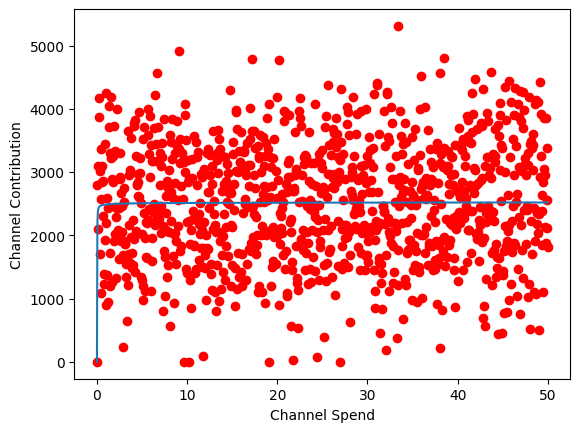

In [12]:
y_pred=mcmc.get_samples()['mu'].mean(axis=0)

plt.scatter(x,y_noise, color='red',label="y_true")
plt.xlabel("Channel Spend")
plt.ylabel("Channel Contribution")
plt.plot(x,y_pred, label='y_pred')

print(f"MAPE: {mean_absolute_percentage_error(y,y_pred)}")

In [13]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  beta_media   2528.99     40.03   2521.56   2485.34   2621.65     10.89      1.03
    half_eff      0.01      0.01      0.01      0.00      0.02    131.05      1.00
         lag      0.32      0.22      0.28      0.00      0.67    252.81      1.00
    sigma[0]    711.51     11.83    711.61    690.04    727.03     47.86      1.03
       slope      1.90      1.19      1.80      0.30      3.57     40.53      1.00

Number of divergences: 24


El segundo modelo va a tener otras priors, intentando reducir el lag_weight y
K y S

In [14]:
## Note: we are using different concetrations
## In this case, we are reducing adstock as well as the diminishing point and slop of the curve

def hill_model2(x,cost,y):
    beta_media=numpyro.sample("beta_media", dist.HalfNormal(cost*0.1))
    half_eff  =numpyro.sample("half_eff",   dist.Gamma(concentration=0.1, rate=1.))
    lag       =numpyro.sample("lag",        dist.Beta(concentration1=0.1, concentration0=1.))
    slope_    =numpyro.sample("slope",      dist.Gamma(concentration=0.1, rate=1.))


    y_pred=numpyro.deterministic('y_pred',beta_media*hill(
            data=adstock(
                data=x.reshape(-1,1), lag_weight=lag, normalise=True),
            half_max_effective_concentration=half_eff,
            slope=slope_))
    mu = numpyro.deterministic(name="mu", value=y_pred)

    with numpyro.plate(name="sigma_plate", size=1):
        sigma = numpyro.sample(
            name="sigma",
            fn=dist.Gamma(concentration=1., rate=1.))

    numpyro.sample(
      name="target", fn=dist.Normal(loc=mu, scale=sigma), obs=y)

In [15]:
nuts_kernel = NUTS(hill_model2, adapt_step_size=True)
mcmc2       = MCMC(nuts_kernel, num_chains=1, num_warmup=400, num_samples=400)

rng_key     = PRNGKey(12)
mcmc2.run(rng_key, x=x, cost=cost, y=y_noise)

sample: 100%|██████████| 800/800 [00:15<00:00, 52.65it/s, 15 steps of size 1.39e-01. acc. prob=0.90]  


MAPE: 0.16481196072694415


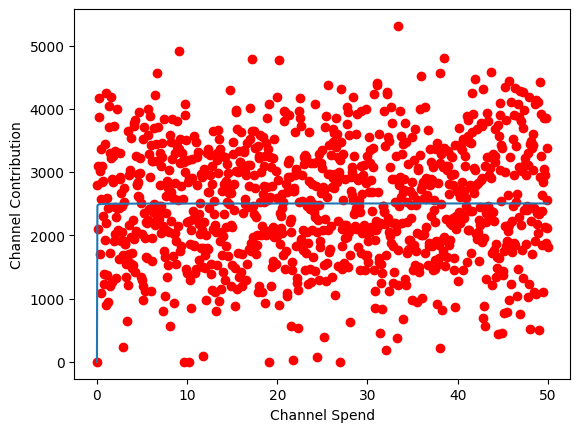

In [16]:
y_pred2=mcmc2.get_samples()['mu'].mean(axis=0)

plt.scatter(x,y_noise, color='red',label="y_true")
plt.xlabel("Channel Spend")
plt.ylabel("Channel Contribution")
plt.plot(x,y_pred2.squeeze(), label='y_pred')
print(f"MAPE: {mean_absolute_percentage_error(y,y_pred2)}")

In [17]:
mcmc2.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  beta_media   2507.53     22.13   2507.59   2469.82   2539.09    296.84      1.00
    half_eff      0.00      0.00      0.00      0.00      0.00    251.30      1.02
         lag      0.10      0.19      0.00      0.00      0.41    393.92      1.00
    sigma[0]    709.13     11.84    709.29    691.97    729.37    135.14      1.00
       slope      0.86      0.66      0.68      0.12      1.56    167.53      1.00

Number of divergences: 1


+ `beta_media` ha bajado mínimamente, de 8866.27 a 8824.22
+ `lag_weight`: ha **bajado considerablemente**, de 0.74 a 0.03
+ $K$ (`half_eff`): ha **subido**, de 3.95 a 4.86
+ $S$ (`slope`): ha **subido**, de 3.68 a 4.34

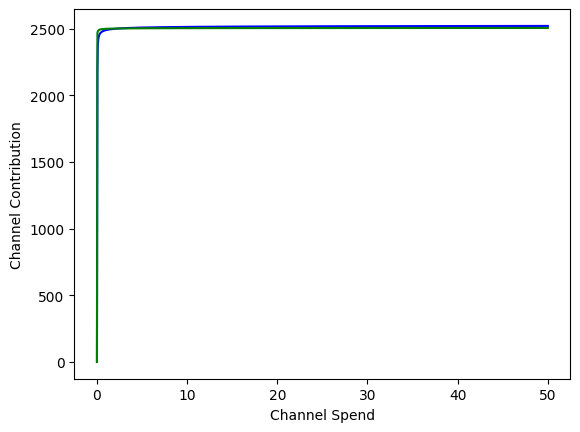

In [18]:
# plt.scatter(x,y_noise, color='red',label="y_true")
plt.xlabel("Channel Spend")
plt.ylabel("Channel Contribution")
plt.plot(x,y_pred.squeeze(),  label='y_pred', color = "blue")
plt.plot(x,y_pred2.squeeze(), label='y_pred', color = "green")

# Back to Precision 32

In [19]:
# https://github.com/google/lightweight_mmm/issues/136

from jax.config import config
config.update('jax_enable_x64', False)